In [1]:
import pandas as pd

In [2]:
#!pip install catboost

In [3]:
#load data
# segment = 'NTC'
# X = pd.read_csv(f'./Wrangled_Data/wrangled_{segment}.csv')
cat_features = ['product_description', 'marital_status', 'occupation_type','industry_grp',
                'res_city_grp','res_state_grp','res_resident_status_grp','branch_grp',
                'manufacturer_grp', 'gender','nature_of_business','channel_grp','asset_model_grp']

In [4]:
def cb_model_builder2( depth = 6,
                     learning_rate = 0.03,
                     iterations =1000,
                     l2_leaf_reg = 3.0,
                     border_count = 50,
                     bagging_temperature = 1,
                     random_strength = 1,
                     od_wait = 10,
                     auto_class_weights = "Balanced",
                     random_state = 42,
                     objective = 'Logloss',
                     cat_features = cat_features
                    ):
    
    from catboost import CatBoostClassifier
    #catboost implementation
    model = CatBoostClassifier(depth = depth,
                     learning_rate = learning_rate,
                     iterations =iterations,
                     l2_leaf_reg = l2_leaf_reg,
                     border_count = border_count,
                     bagging_temperature = bagging_temperature,
                     random_strength = random_strength,
                     od_wait = od_wait,
                     auto_class_weights = auto_class_weights,
                     random_state = random_state,
                     objective = objective,
                     cat_features = cat_features)
    
    return model

In [5]:
def CB_model_auc(cleaned_df, catboost_model, segment):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    from sklearn.model_selection import (train_test_split, GridSearchCV)
    from sklearn.preprocessing import OneHotEncoder
    from catboost import CatBoostClassifier, Pool

    from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc
    from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score
    from catboost.utils import get_confusion_matrix, get_roc_curve, get_fnr_curve, get_fpr_curve
    from sklearn.metrics import RocCurveDisplay
    from sklearn import metrics

    from sklearn.model_selection import RandomizedSearchCV
    
    y = 'D3_within12months'
    X = cleaned_df.drop(columns = [y, 'loan_account_no'])
    y = cleaned_df[y]

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 11, train_size = 0.8,
                                                        test_size = 0.2, stratify = y)

    cat_features = X_train.select_dtypes(include=['object','category']).columns.tolist()

    # train_data = Pool(data=X_train,
    #              label = y_train,
    #              cat_features=cat_features)

    model = catboost_model

    model.fit(X_train, y_train)

    y_pred_proba = model.predict_proba(X_test)[:,1]

    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred_proba)
    
    #compute optimal threshold based on roc_auc curve only
    opt = true_positive_rate - false_positive_rate
    tp_fp_diff = pd.DataFrame({'thresholds': threshold, 'tpr_fpr': opt})

    max_index = tp_fp_diff.tpr_fpr.argmax()
    THRESHOLD = tp_fp_diff.iloc[max_index][0]
    
    y_pred = np.where(y_pred_proba > THRESHOLD, 1, 0)

    plt.subplots(1, figsize = (5,5))
    luh = roc_auc_score(y_test, y_pred_proba)
    plt.title(f'ROC_AUC Curve: {luh:.2f}')
    plt.plot(false_positive_rate, true_positive_rate)
    plt.plot([0,1], ls = "--")
    plt.plot([0,0],[1,0], c= ".7"), plt.plot([1,1], c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    print(classification_report(y_test, y_pred, target_names = ['Good Customer','Bad Customer']))
    cnf_matrix = metrics.confusion_matrix(y_test,y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(cnf_matrix)
    print(tn, fp, fn, tp)
    
    sns.distplot(y_pred_proba)
    plt.show()

    feat_importances = model.feature_importances_
    feature_names = model.feature_names_

    feat_imp_df = pd.DataFrame({
        'variable':feature_names,
        'feature_importances':feat_importances
    })
    
    feat_imp_df.to_csv(f'./Feature_Importance/featimportance_CB_{segment}.csv', index=False)

    feat_imp_df = feat_imp_df.sort_values(by='feature_importances', ascending=False)
    print(feat_imp_df[:20])

0:	learn: 0.6890620	total: 246ms	remaining: 1m 18s
1:	learn: 0.6818848	total: 299ms	remaining: 47.4s
2:	learn: 0.6757377	total: 356ms	remaining: 37.5s
3:	learn: 0.6696944	total: 403ms	remaining: 31.8s
4:	learn: 0.6660203	total: 459ms	remaining: 28.8s
5:	learn: 0.6612059	total: 508ms	remaining: 26.5s
6:	learn: 0.6561270	total: 550ms	remaining: 24.5s
7:	learn: 0.6529475	total: 597ms	remaining: 23.2s
8:	learn: 0.6501295	total: 641ms	remaining: 22.1s
9:	learn: 0.6468235	total: 685ms	remaining: 21.2s
10:	learn: 0.6447075	total: 736ms	remaining: 20.6s
11:	learn: 0.6426954	total: 796ms	remaining: 20.4s
12:	learn: 0.6411125	total: 845ms	remaining: 19.9s
13:	learn: 0.6403340	total: 888ms	remaining: 19.4s
14:	learn: 0.6376090	total: 951ms	remaining: 19.3s
15:	learn: 0.6357478	total: 993ms	remaining: 18.8s
16:	learn: 0.6354890	total: 1.03s	remaining: 18.2s
17:	learn: 0.6347725	total: 1.07s	remaining: 18s
18:	learn: 0.6347115	total: 1.1s	remaining: 17.4s
19:	learn: 0.6335315	total: 1.15s	remaining

C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_22144\1404315374.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  THRESHOLD = tp_fp_diff.iloc[max_index][0]


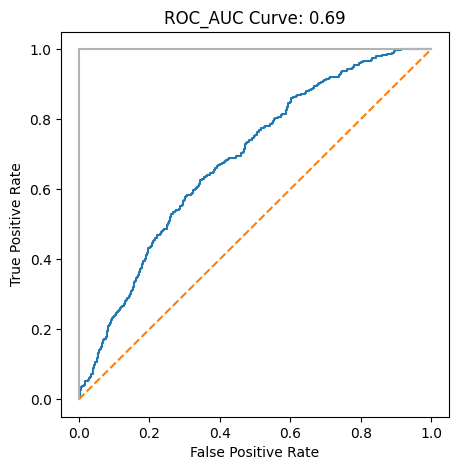

C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_22144\1404315374.py:66: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred_proba)


               precision    recall  f1-score   support

Good Customer       0.95      0.66      0.78      3336
 Bad Customer       0.15      0.62      0.24       320

     accuracy                           0.65      3656
    macro avg       0.55      0.64      0.51      3656
 weighted avg       0.88      0.65      0.73      3656

[[2188 1148]
 [ 121  199]]
2188 1148 121 199


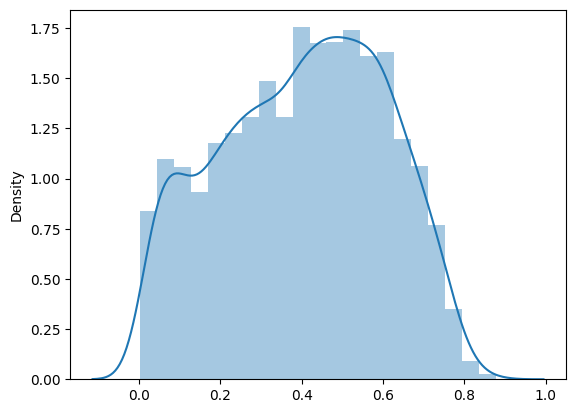

                        variable  feature_importances
15                      dp_ratio            12.289171
3            down_payment_amount            11.069197
8                loan_asset_cost             8.834837
2                            age             7.779570
7         number_of_installments             7.602564
22                 res_state_grp             6.281348
19                    branch_grp             5.838444
9   res_years_at_current_address             5.766617
21                  res_city_grp             5.689037
1      res_years_at_current_city             4.599376
20               asset_model_grp             3.596722
14                monthly_income             3.294920
6                  interest_rate             2.905338
4                   total_income             2.767543
16              manufacturer_grp             2.190832
5                occupation_type             1.931909
23       res_resident_status_grp             1.832438
13           years_in_occupa

In [6]:
#NTC_level: tuned
#cat_features = X_train.select_dtypes(include=['object','category']).columns.tolist()
cat_features = ['product_description', 'marital_status', 'occupation_type','industry_grp',
                'res_city_grp','res_state_grp','res_resident_status_grp','branch_grp',
                'manufacturer_grp', 'gender','nature_of_business','channel_grp','asset_model_grp']
cbc_ntc_vf = cb_model_builder2( depth = 4,
                     learning_rate = 0.0979722306417506,
                     iterations =319,
                     l2_leaf_reg = 10.909079937846313,
                     border_count = 233,
                     bagging_temperature = 1.349262400109297,
                     random_strength = 1.959828624191452,
                     od_wait = 87,
                     auto_class_weights = "Balanced",
                     random_state = 42,
                     objective = 'Logloss',
                     cat_features = cat_features
                    )
segment = 'NTC'
X = pd.read_csv(f'./Wrangled_Data/wrangled_{segment}.csv')
CB_model_auc(X, cbc_ntc_vf, segment)

0:	learn: 0.6927557	total: 84ms	remaining: 17.2s
1:	learn: 0.6922597	total: 130ms	remaining: 13.3s
2:	learn: 0.6917810	total: 165ms	remaining: 11.2s
3:	learn: 0.6913970	total: 222ms	remaining: 11.2s
4:	learn: 0.6893538	total: 337ms	remaining: 13.5s
5:	learn: 0.6889094	total: 380ms	remaining: 12.7s
6:	learn: 0.6879901	total: 412ms	remaining: 11.7s
7:	learn: 0.6868526	total: 531ms	remaining: 13.2s
8:	learn: 0.6866222	total: 568ms	remaining: 12.4s
9:	learn: 0.6860027	total: 656ms	remaining: 12.9s
10:	learn: 0.6856948	total: 705ms	remaining: 12.5s
11:	learn: 0.6849538	total: 748ms	remaining: 12.1s
12:	learn: 0.6844163	total: 781ms	remaining: 11.6s
13:	learn: 0.6839307	total: 852ms	remaining: 11.7s
14:	learn: 0.6833676	total: 902ms	remaining: 11.5s
15:	learn: 0.6831833	total: 936ms	remaining: 11.1s
16:	learn: 0.6822628	total: 1.04s	remaining: 11.6s
17:	learn: 0.6820973	total: 1.12s	remaining: 11.7s
18:	learn: 0.6815971	total: 1.16s	remaining: 11.4s
19:	learn: 0.6815971	total: 1.17s	remainin

C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_22144\1404315374.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  THRESHOLD = tp_fp_diff.iloc[max_index][0]


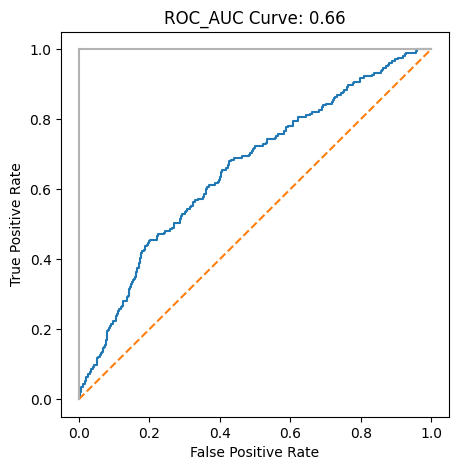

C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_22144\1404315374.py:66: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred_proba)


               precision    recall  f1-score   support

Good Customer       0.94      0.80      0.86      2068
 Bad Customer       0.18      0.45      0.26       206

     accuracy                           0.77      2274
    macro avg       0.56      0.62      0.56      2274
 weighted avg       0.87      0.77      0.81      2274

[[1648  420]
 [ 113   93]]
1648 420 113 93


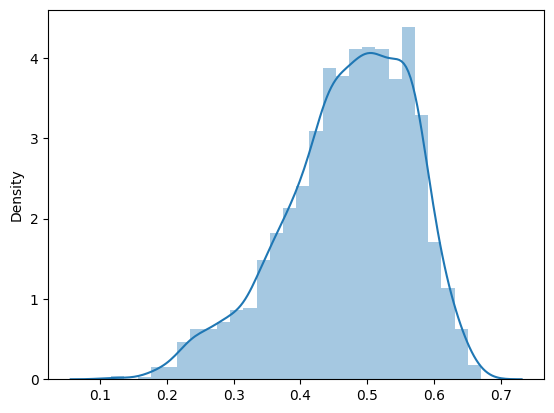

                        variable  feature_importances
7         number_of_installments            18.704767
15                      dp_ratio            12.877721
19                    branch_grp             8.326918
2                            age             8.305062
22                 res_state_grp             6.188700
21                  res_city_grp             6.117635
3            down_payment_amount             5.304397
16              manufacturer_grp             4.261112
5                occupation_type             4.095515
18                  industry_grp             3.746564
20               asset_model_grp             3.517055
11                marital_status             3.343474
12            nature_of_business             3.155765
8                loan_asset_cost             2.936623
14                monthly_income             1.836066
23       res_resident_status_grp             1.766653
6                  interest_rate             1.727309
4                   total_in

In [7]:
#low_CIBIL_level: tuned
cat_features = ['product_description', 'marital_status', 'occupation_type','industry_grp',
                'res_city_grp','res_state_grp','res_resident_status_grp','branch_grp',
                'manufacturer_grp', 'gender','nature_of_business','channel_grp','asset_model_grp']
cbc_low_CIBIL_vf = cb_model_builder2( depth = 9,
                     learning_rate = 0.022375193103931247,
                     iterations =206,
                     l2_leaf_reg = 12.032954711310595,
                     border_count = 155,
                     bagging_temperature = 0.8428035290621423,
                     random_strength = 4.234014807063696,
                     od_wait = 80,
                     auto_class_weights = "Balanced",
                     random_state = 42,
                     objective = 'Logloss',
                     cat_features = cat_features
                    )
segment = 'low_CIBIL'
X = pd.read_csv(f'./Wrangled_Data/wrangled_{segment}.csv')
CB_model_auc(X, cbc_low_CIBIL_vf, segment)

0:	learn: 0.6924171	total: 17.3ms	remaining: 3.54s
1:	learn: 0.6917651	total: 101ms	remaining: 10.3s
2:	learn: 0.6917123	total: 155ms	remaining: 10.5s
3:	learn: 0.6902910	total: 226ms	remaining: 11.4s
4:	learn: 0.6902359	total: 263ms	remaining: 10.6s
5:	learn: 0.6879658	total: 378ms	remaining: 12.6s
6:	learn: 0.6876017	total: 412ms	remaining: 11.7s
7:	learn: 0.6874671	total: 465ms	remaining: 11.5s
8:	learn: 0.6874671	total: 476ms	remaining: 10.4s
9:	learn: 0.6869349	total: 519ms	remaining: 10.2s
10:	learn: 0.6863399	total: 547ms	remaining: 9.7s
11:	learn: 0.6851856	total: 610ms	remaining: 9.87s
12:	learn: 0.6846992	total: 631ms	remaining: 9.37s
13:	learn: 0.6834842	total: 691ms	remaining: 9.48s
14:	learn: 0.6816783	total: 827ms	remaining: 10.5s
15:	learn: 0.6811308	total: 873ms	remaining: 10.4s
16:	learn: 0.6808452	total: 899ms	remaining: 9.99s
17:	learn: 0.6800237	total: 931ms	remaining: 9.73s
18:	learn: 0.6800237	total: 941ms	remaining: 9.26s
19:	learn: 0.6792963	total: 1.05s	remaini

C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_22144\1404315374.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  THRESHOLD = tp_fp_diff.iloc[max_index][0]


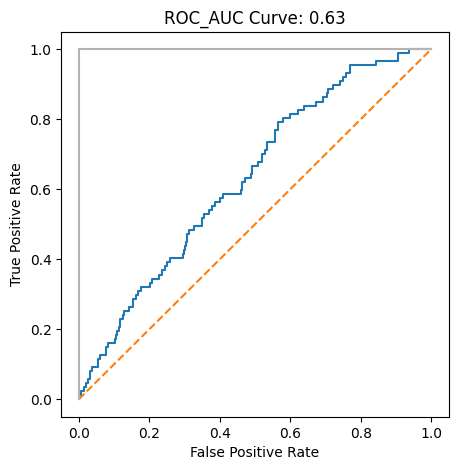

C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_22144\1404315374.py:66: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred_proba)


               precision    recall  f1-score   support

Good Customer       0.97      0.44      0.60      1398
 Bad Customer       0.08      0.78      0.14        87

     accuracy                           0.46      1485
    macro avg       0.52      0.61      0.37      1485
 weighted avg       0.92      0.46      0.57      1485

[[609 789]
 [ 19  68]]
609 789 19 68


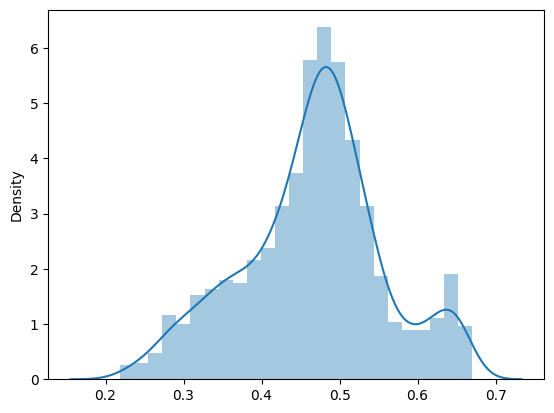

                        variable  feature_importances
15                      dp_ratio            15.547861
19                    branch_grp            10.203043
3            down_payment_amount             7.756865
7         number_of_installments             7.468450
22                 res_state_grp             6.195133
21                  res_city_grp             5.939407
23       res_resident_status_grp             4.848195
18                  industry_grp             4.640276
5                occupation_type             4.209339
12            nature_of_business             4.111729
20               asset_model_grp             3.923532
9   res_years_at_current_address             3.582497
6                  interest_rate             3.505386
2                            age             3.344020
11                marital_status             3.132688
4                   total_income             2.631058
8                loan_asset_cost             2.600598
16              manufacturer

In [8]:
#mid_CIBIL_level: tuned
cat_features = ['product_description', 'marital_status', 'occupation_type','industry_grp',
                'res_city_grp','res_state_grp','res_resident_status_grp','branch_grp',
                'manufacturer_grp', 'gender','nature_of_business','channel_grp','asset_model_grp']
cbc_mid_CIBIL_vf = cb_model_builder2( depth = 9,
                     learning_rate = 0.022375193103931247,
                     iterations =206,
                     l2_leaf_reg = 12.032954711310595,
                     border_count = 155,
                     bagging_temperature = 0.8428035290621423,
                     random_strength = 4.234014807063696,
                     od_wait = 80,
                     auto_class_weights = "Balanced",
                     random_state = 42,
                     objective = 'Logloss',
                     cat_features = cat_features
                    )
segment = 'mid_CIBIL'
X = pd.read_csv(f'./Wrangled_Data/wrangled_{segment}.csv')
CB_model_auc(X, cbc_mid_CIBIL_vf, segment)

0:	learn: 0.6912594	total: 141ms	remaining: 28.9s
1:	learn: 0.6907128	total: 191ms	remaining: 19.5s
2:	learn: 0.6882686	total: 294ms	remaining: 19.9s
3:	learn: 0.6856388	total: 389ms	remaining: 19.6s
4:	learn: 0.6856388	total: 408ms	remaining: 16.4s
5:	learn: 0.6834291	total: 545ms	remaining: 18.2s
6:	learn: 0.6834291	total: 566ms	remaining: 16.1s
7:	learn: 0.6826861	total: 617ms	remaining: 15.3s
8:	learn: 0.6815496	total: 732ms	remaining: 16s
9:	learn: 0.6813043	total: 758ms	remaining: 14.8s
10:	learn: 0.6795669	total: 826ms	remaining: 14.6s
11:	learn: 0.6765650	total: 924ms	remaining: 14.9s
12:	learn: 0.6751832	total: 995ms	remaining: 14.8s
13:	learn: 0.6703384	total: 1.1s	remaining: 15.1s
14:	learn: 0.6693156	total: 1.15s	remaining: 14.6s
15:	learn: 0.6681256	total: 1.2s	remaining: 14.2s
16:	learn: 0.6652313	total: 1.31s	remaining: 14.6s
17:	learn: 0.6627218	total: 1.41s	remaining: 14.7s
18:	learn: 0.6627217	total: 1.43s	remaining: 14.1s
19:	learn: 0.6625489	total: 1.5s	remaining: 1

C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_22144\1404315374.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  THRESHOLD = tp_fp_diff.iloc[max_index][0]


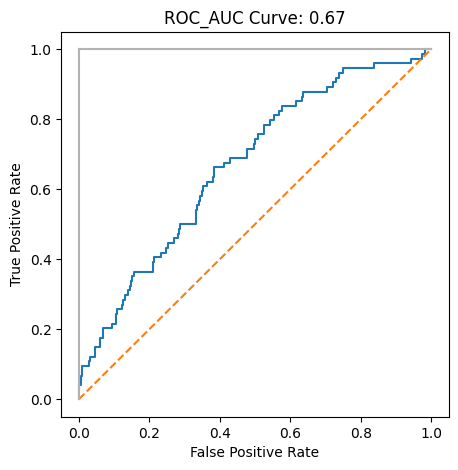

C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_22144\1404315374.py:66: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred_proba)


               precision    recall  f1-score   support

Good Customer       0.98      0.62      0.76      2448
 Bad Customer       0.05      0.65      0.09        74

     accuracy                           0.62      2522
    macro avg       0.52      0.63      0.42      2522
 weighted avg       0.96      0.62      0.74      2522

[[1510  938]
 [  26   48]]
1510 938 26 48


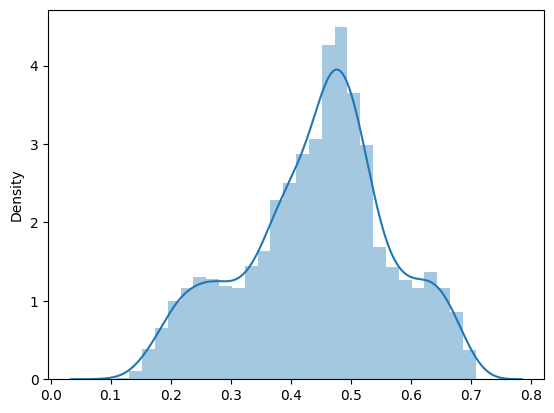

                     variable  feature_importances
3         down_payment_amount            16.961203
7      number_of_installments            12.173173
15                   dp_ratio            10.427264
22              res_state_grp             8.754422
19                 branch_grp             7.785223
21               res_city_grp             5.911345
23    res_resident_status_grp             4.087831
16           manufacturer_grp             3.958651
11             marital_status             3.755410
12         nature_of_business             3.576777
18               industry_grp             3.574347
5             occupation_type             3.412167
6               interest_rate             2.812333
2                         age             2.811394
20            asset_model_grp             2.197012
4                total_income             1.933285
14             monthly_income             1.408193
10                     gender             1.249536
1   res_years_at_current_city  

In [9]:
#high_CIBIL_level: tuned
cat_features = ['product_description', 'marital_status', 'occupation_type','industry_grp',
                'res_city_grp','res_state_grp','res_resident_status_grp','branch_grp',
                'manufacturer_grp', 'gender','nature_of_business','channel_grp','asset_model_grp']
cbc_high_CIBIL_vf = cb_model_builder2( depth = 9,
                     learning_rate = 0.022375193103931247,
                     iterations =206,
                     l2_leaf_reg = 12.032954711310595,
                     border_count = 155,
                     bagging_temperature = 0.8428035290621423,
                     random_strength = 4.234014807063696,
                     od_wait = 80,
                     auto_class_weights = "Balanced",
                     random_state = 42,
                     objective = 'Logloss',
                     cat_features = cat_features
                    )
segment = 'high_CIBIL'
X = pd.read_csv(f'./Wrangled_Data/wrangled_{segment}.csv')
CB_model_auc(X, cbc_high_CIBIL_vf, segment)